In [1]:
import torch

# assert torch.cuda.is_available()

from deepxdeAbeta import deepxde as dde

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import os
import shutil
import time

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
backend = "pytorch"

In [3]:
dde.config.set_default_float("float64")
dde.backend.set_default_backend(backend)

Set the default float type to float64
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [4]:
max_time = 10
num_rows = 200

In [5]:
def to_npz(filepath, out_path, x_cols, y_cols):
    df = pd.read_csv(filepath)
    t = []
    y = []
    for _, v in df.iterrows():
        t.append(v[x_cols].to_numpy())
        y.append(v[y_cols].to_numpy())
    np.savez(out_path, t=t, y=y)


def load_training_data(data_path):
    tr_data = np.load(data_path)
    return tr_data['t'], tr_data['y']

In [6]:
geom = dde.geometry.TimeDomain(0, max_time)


# Helper function that is used to check whether a point is an initial point or not. This is only used by DeepXDE
def boundary(_, on_initial):
    return on_initial


num_hidden_layers = 5
hidden_layer_size = 32
output_layer = 5

layers = [1] + [hidden_layer_size] * num_hidden_layers + [output_layer]

activation = ['tanh']*num_hidden_layers + ['tanh']

iterations = 50_000
optimizer = "adam"
learning_rate = 1e-04

In [7]:
model_num = 8 #TODO
model_dir = 'binning_trials/models/model' + str(model_num)
datafile = 'binning_trials/model' + str(model_num) + '.csv'

In [8]:
#IMPORTS
# from binning_trials.binned_models import *
a1, a2, a3, a4, a5, a6, a7, a8 = [
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0)),
dde.Variable(np.float64(0))
]
n, m, p, s = np.float64(1.4), np.float64(2/1.4), np.float64(5/3), np.float64(3/2)
def equations(x, y):
    # print(y)
    B1, B1_4, B2, B3, B5 = abs(y[:, 0:1]), abs(y[:, 1:2]), abs(y[:, 2:3]), abs(y[:, 3:4]), abs(y[:, 4:5])
    # tf.print(x, output_stream=sys.stderr, summarize=10)

    B1t = dde.grad.jacobian(y, x, i=0)
    B1_4t = dde.grad.jacobian(y, x, i=1)
    B2t = dde.grad.jacobian(y, x, i=2)
    B3t = dde.grad.jacobian(y, x, i=3)
    B5t = dde.grad.jacobian(y, x, i=4)

    # print(B1_35)

    # calculates residuals by subtracting right side from left side of each equation.
    # Left side is calculated with respect to time, right side is calculated with the other species.
    # Finding the correct constants to make residuals = 0; essentially residual = loss to be minimized.
    r_b1 = B1t - (a1*n*B1_4 - a2*n*pow(B1, n))
    r_b1_4 = B1_4t - (a2*pow(B1, n) - a1*B1_4 + a3*m*B2 - a4*m*pow(B1_4, m))
    r_b2 = B2t - (a4*pow(B1_4, m) - a3*B2 + a5*s*B3 - a6*s*pow(B2, s))
    r_b3 = B3t - (a6*pow(B2, s) - a5*B3 + a7*p*B5 - a8*p*pow(B3, p))
    r_b5 = B5t - (a8*pow(B3, p) - a7*B5)

    return [r_b1, r_b1_4, r_b2, r_b3, r_b5]

initial_conditions = [1.39E-06,2.65E-06,5.42E-06,1.23E-05,3.55E-05]
y_cols = ["1uM","1.4uM","2uM","3uM","5uM"]

Compiling model...
'compile' took 0.000170 s

Training model...

Step      Train loss                                                                                                                                                Test loss                                                                                                                                                 Test metric
0         [4.90e-04, 3.24e-02, 4.70e-03, 1.05e-03, 3.68e-03, 1.93e-12, 7.02e-12, 2.94e-11, 1.51e-10, 1.26e-09, 3.08e-01, 2.46e+00, 2.92e-01, 8.43e-01, 1.65e+00]    [4.90e-04, 3.24e-02, 4.70e-03, 1.05e-03, 3.68e-03, 1.93e-12, 7.02e-12, 2.94e-11, 1.51e-10, 1.26e-09, 3.08e-01, 2.46e+00, 2.92e-01, 8.43e-01, 1.65e+00]    []  
500       [4.11e-03, 7.09e-03, 1.04e-02, 2.77e-02, 3.86e-02, 5.42e-05, 1.14e-04, 1.45e-05, 1.48e-04, 3.19e-03, 1.28e-02, 1.61e-02, 2.67e-02, 1.59e-02, 2.09e-02]    [4.11e-03, 7.09e-03, 1.04e-02, 2.77e-02, 3.86e-02, 5.42e-05, 1.14e-04, 1.45e-05, 1.48e-04, 3.19e-03, 1.28e-02, 1.61e-0

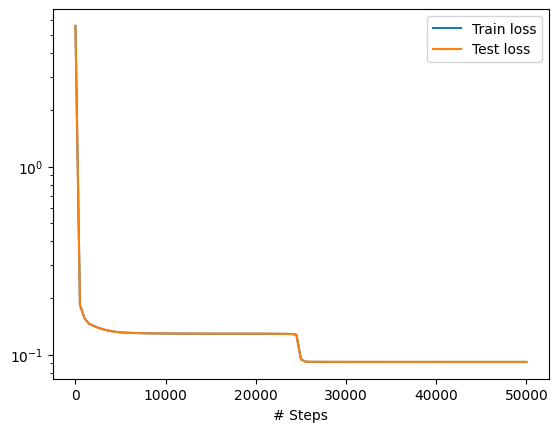

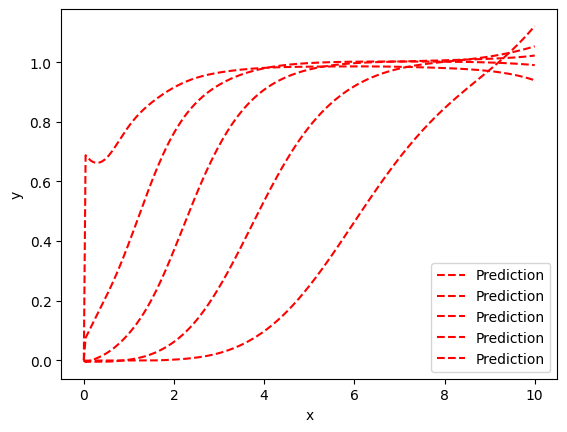

In [9]:
variable = dde.callbacks.VariableValue(
    [a1, a2, a3, a4, a5, a6, a7, a8],
    period=(iterations//100 if iterations > 99 else 1),
    filename=model_dir+'/variables.dat')

start = time.time()

to_npz(datafile, 'model' + str(model_num) + '.npz', x_cols=['t'], y_cols=y_cols)
ob_t, ob_y = load_training_data('model' + str(model_num) + '.npz')
# print(ob_y1.values, ob_y2.values, ob_y3.values)
ic1 = dde.icbc.IC(geom, lambda X: initial_conditions[0], boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: initial_conditions[1], boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: initial_conditions[2], boundary, component=2)
ic4 = dde.icbc.IC(geom, lambda X: initial_conditions[3], boundary, component=3)
ic5 = dde.icbc.IC(geom, lambda X: initial_conditions[4], boundary, component=4)


ob_y1 = dde.icbc.PointSetBC(ob_t, ob_y[:, 0:1], component=0)
ob_y2 = dde.icbc.PointSetBC(ob_t, ob_y[:, 1:2], component=1)
ob_y3 = dde.icbc.PointSetBC(ob_t, ob_y[:, 2:3], component=2)
ob_y4 = dde.icbc.PointSetBC(ob_t, ob_y[:, 3:4], component=3)
ob_y5 = dde.icbc.PointSetBC(ob_t, ob_y[:, 4:5], component=4)


data = dde.data.PDE(
    geom,
    equations,
    [ic1, ic2, ic3, ic4, ic5, ob_y1, ob_y2, ob_y3, ob_y4, ob_y5],
    num_domain=199, #TODO
    num_boundary=1, #TODO
    anchors=ob_t
)

network = dde.nn.FNN(layers, activation, 'Glorot uniform')
model = dde.Model(data, network)

model.compile(optimizer, lr=learning_rate,
              external_trainable_variables=[a1, a2, a3, a4, a5, a6, a7, a8])

loss_history, train_state = model.train(
    epochs=iterations, callbacks=[variable], display_every=
    (iterations // 100 if iterations > 99 else 1)
    ,
    disregard_previous_best=True
)


dde.saveplot(loss_history, train_state, issave=True, isplot=False, output_dir=f'{model_dir}')
dde.utils.external.plot_loss_history(loss_history,
                                     fname=f'{model_dir}/loss_history'
                                     )
dde.utils.external.plot_best_state(train_state,
                                   fname=f'{model_dir}/train_state'
                                   )

pred = model.predict(ob_t, operator=equations)
model.save(f'{model_dir}/nonneg_constr')

with open(f'{model_dir}/info.dat', 'x') as f:

    lines = [
        f'training time: {time.time() - start}\n',
        f'residual: {np.mean(np.absolute(pred))}\n'
        f'best model at: {train_state.best_step}\n'
        f'train loss: {train_state.best_loss_train}\n'
    ]

    f.writelines(lines)
